In [1]:
# Import libraries
import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot

2025-09-06 17:30:26.018798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757179826.213801      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757179826.274728      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set your correct dataset directory
dataset_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

In [3]:
# Define the image dimensions
img_height, img_width = 224, 224

In [4]:

# Load and preprocess the data
def load_data(dataset_dir):
    images = []
    labels = []

    # List the main folders
    main_folders = ['colon_image_sets', 'lung_image_sets']

    for main_folder in main_folders:
        main_path = os.path.join(dataset_dir, main_folder)
        for folder in os.listdir(main_path):
            label = folder
            folder_path = os.path.join(main_path, folder)
            for filename in os.listdir(folder_path):
                img = cv2.imread(os.path.join(folder_path, filename))
                img = cv2.resize(img, (img_height, img_width))
                images.append(img)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    
images, labels = load_data(dataset_dir)

In [5]:
# Encode labels (Map class names to numbers)
label_dict = {
    'colon_aca': 0, 
    'colon_n': 1, 
    'lung_aca': 2, 
    'lung_n': 3, 
    'lung_scc': 4
}
labels = np.array([label_dict[label] for label in labels])
labels = to_categorical(labels)

In [6]:

# Split the data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

I0000 00:00:1757180148.845068      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757180148.845762      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Add custom top layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes
])

In [9]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    verbose=1,
    patience=3,         # Stop if no improvement for 3 epochs
    restore_best_weights=True  # Restore best model weights
)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [11]:
# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_reduce]  
)

Epoch 1/200


I0000 00:00:1757180192.125486      97 service.cc:148] XLA service 0x7c72cc0715b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757180192.126315      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757180192.126337      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757180195.315729      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757180212.543928      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 ━━━━━━━━━━━━━━━━━━━━ 134s 143ms/step - accuracy: 0.9180 - loss: 0.2433 - val_accuracy: 0.3211 - val_loss: 19.7396 - learning_rate: 0.0010
Epoch 2/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 0.9774 - loss: 0.0703 - val_accuracy: 0.2861 - val_loss: 26.1467 - learning_rate: 0.0010
Epoch 3/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - accuracy: 0.9763 - loss: 0.0691 - val_accuracy: 0.2275 - val_loss: 22.7938 - learning_rate: 0.0010
Epoch 4/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.9914 - loss: 0.0317 - val_accuracy: 0.8168 - val_loss: 1.4737 - learning_rate: 2.0000e-04
Epoch 5/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 58s 107ms/step - accuracy: 0.9956 - loss: 0.0125 - val_accuracy: 0.9867 - val_loss: 0.0496 - learning_rate: 2.0000e-04
Epoch 6/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 58s 107ms/step - accuracy: 0.9973 - loss: 0.0084 - val_accuracy: 0.9861 - val_loss: 0.0416 - learning_rate: 2.0000e-04
Epoch 7/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 58s 107ms/step - ac

              precision    recall  f1-score   support

   colon_aca      1.000     1.000     1.000       771
     colon_n      1.000     1.000     1.000       750
    lung_aca      1.000     0.999     0.999       755
      lung_n      1.000     1.000     1.000       724
    lung_scc      0.999     1.000     0.999       750

    accuracy                          1.000      3750
   macro avg      1.000     1.000     1.000      3750
weighted avg      1.000     1.000     1.000      3750



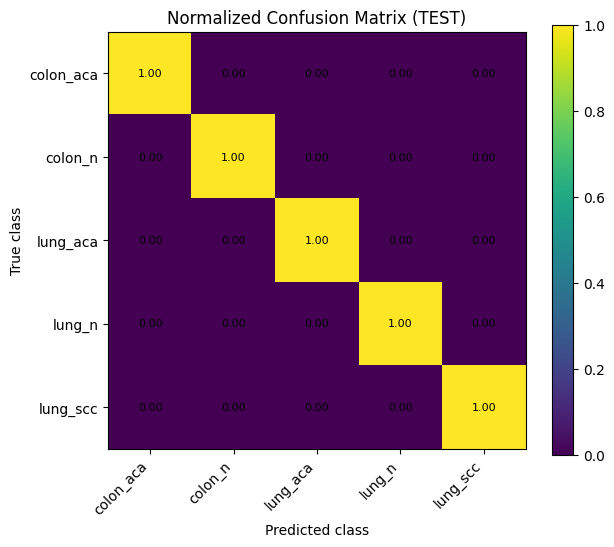

In [12]:
# Per-class Precision/Recall/F1 + Confusion Matrix 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

# choose split (TEST preferred; falls back to VAL)
if 'X_test' in globals() and 'y_test' in globals():
    X_eval, y_eval, split_name = X_test, y_test, "TEST"
else:
    X_eval, y_eval, split_name = X_val, y_val, "VAL"

# class names from your label_dict
inv = {v: k for k, v in label_dict.items()}
class_names = [inv[i] for i in range(len(inv))]
num_classes = len(class_names)

y_true = np.argmax(y_eval, axis=1)                # ground-truth ints
y_pred = np.argmax(model.predict(X_eval, 32, 0), axis=1)  # predicted ints

# report
rep_txt = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print(rep_txt)

os.makedirs("metrics", exist_ok=True)
with open("metrics/classification_report.txt", "w") as f:
    f.write(rep_txt)
pd.DataFrame(
    classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=3)
).transpose().to_csv("metrics/per_class_report.csv")

# confusion matrix (normalized)
cm_raw  = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_norm = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize='true')
np.savetxt("metrics/confusion_matrix_counts.csv", cm_raw, fmt="%d", delimiter=",")

fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(cm_norm, interpolation='nearest'); ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(num_classes), yticks=np.arange(num_classes),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predicted class', ylabel='True class',
       title=f'Normalized Confusion Matrix ({split_name})')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', fontsize=8)
plt.tight_layout()
os.makedirs("figs", exist_ok=True)
plt.savefig("figs/confusion_matrix.png", dpi=300)
plt.savefig("figs/confusion_matrix.pdf")


In [13]:
# After training the model, evaluate on all datasets
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)


Training Accuracy: 1.0000
Validation Accuracy: 0.9997
Test Accuracy: 0.9997


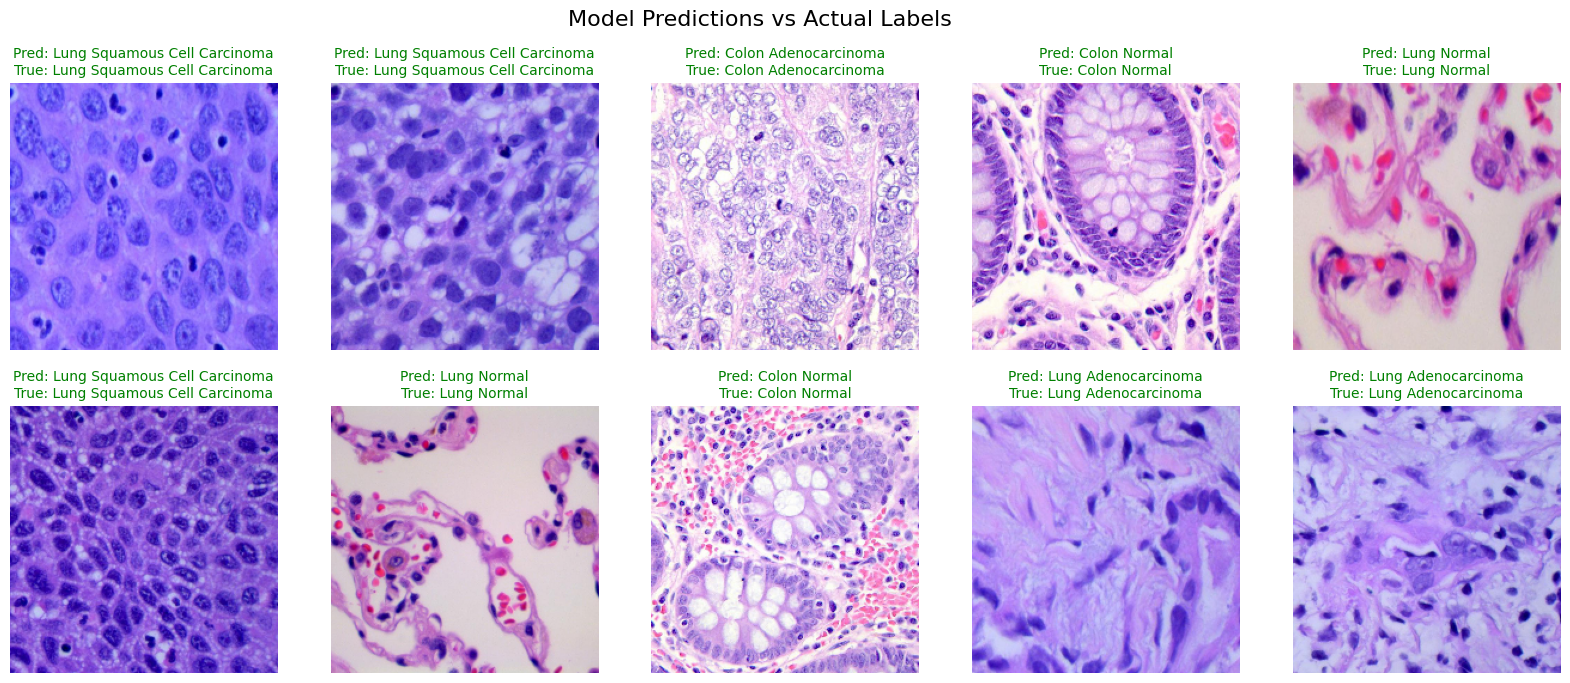

In [14]:
# Print the accuracies
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Visualization of predictions
import matplotlib.pyplot as plt
import random

# Define class names
class_names = [
    "Colon Adenocarcinoma",
    "Colon Normal",
    "Lung Adenocarcinoma",
    "Lung Normal",
    "Lung Squamous Cell Carcinoma"
]

# Convert one-hot encoded labels back to class indices
y_test_indices = np.argmax(y_test, axis=1)

# Randomly select 10 test samples
indices = random.sample(range(len(X_test)), 10)

# Create plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Model Predictions vs Actual Labels', fontsize=16, y=0.94)  # Increased y-position

for i, idx in enumerate(indices):
    ax = axes[i//5, i%5]
    
    # Get image and convert BGR to RGB for display
    image = cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB)
    true_label_idx = y_test_indices[idx]
    
    # Make prediction
    pred = model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0)
    pred_label_idx = np.argmax(pred)
    
    # Display image
    ax.imshow(image)
    ax.axis('off')
    
    # Set title color based on prediction correctness
    title_color = 'green' if pred_label_idx == true_label_idx else 'red'
    ax.set_title(
        f"Pred: {class_names[pred_label_idx]}\nTrue: {class_names[true_label_idx]}",
        color=title_color,
        fontsize=10
    )

# Add more vertical space above the subplots
plt.subplots_adjust(top=0.85) 
plt.show()